# Iterative linear algebra

Even exploiting sparsity, the time to solve a linear system for an elliptic PDE quickly becomes unreasonable as the grid size increases. In terms of the grid spacing $h$, the number of unknowns scales as $O(h^{-2})$ and the time per linear system solution is $O(h^{-4})$. With a convergence rate of 2nd order, a 10-fold decrease in the error requires $h$ to decrease by a factor of $3.3$ and the execution time goes up by a factor of about 120. The situation is even more unmanageable in 3D, where the solution time scales with $O(h^{-6})$. 

There's something unsatisfying about solving a linear system exactly (modulo roundoff) when the solution is itself a low-accuracy representation of the continuous object that is the real target. In other words, if a nodal value has only 3 accurate digits, we don't care that the solution of the discrete system is 0.123456787654, as we are just as happy with 0.123. But factorization-based linear solvers don't give us a choice in the matter.

Thus, as the number of unknowns grows, we seek iterative methods to solve the linear systems. We can stop the iterations once we have as much accuracy as we hope to get from the discretization, potentially saving a lot of time.

## Splitting methods

The OG iterative methods for linear systems are known as **splitting methods**. We rewrite the system matrix as $\bfA=\mathbf{M}-\mathbf{N}$, and $\bfA\bfu=\bfb$ as 

$$
\mathbf{M} \bfu = \mathbf{N} \bfu + \bfb. 
$$

We then perform a fixed-point iteration

$$
\mathbf{M} \bfu_{k+1} = \mathbf{N} \bfu_k + \bfb. 
$$

Clearly this is designed to use a matrix $\mathbf{M}$ that makes it easy to solve the FP systems quickly. The most famous methods are **Jacobi**, which uses

$$
\mathbf{M} = \diag(\diag(\bfA)), 
$$

and **Gauss--Seidel**, which lets $\mathbf{M}$ be the lower triangle of $\bfA$. The convergence of the method depends on convergence of powers of $\mathbf{M}^{-1}\mathbf{N}$ to zero. For a few cases, including Poisson's equation, this convergence is well-understood, to an extent that allows a better variant called *SOR*.

The only reasons to use splitting methods are (a) for a *multigrid* method, which uses the convergence properties cleverly, and/or (b) massively parallel implementations of Jacobi, for which the components of $\bfu_{k+1}$ may be computed independently.

## Krylov methods

In most contexts the preferred iterative methods are **Krylov subspace iterations**. For particular problem types, the best-known choices are

* Any matrix: GMRES
* Symmetric matrix: MINRES 
* SPD matrix: Conjugate gradients (though MINRES is fine)

There are many others, such as QMR, Bi-CGStab, etc.

All of the methods look for a solution of $\bfA\bfu=\bfb$ in the nested subspaces spanned by $\bfb,\bfA\bfb,\bfA^2\bfb,\dots$. They use different iterations to generate them and to find the optimal solution for different definitions of optimality. 

One extremely useful aspect of these methods is that the only way they use the matrix $\bfA$ is by computing the matrix product $\bfA\bfv$ for an arbitrary vector $\bfv$. That is, they just apply the linear transformation implied by $\bfA$. This enables **matrix-free iterations** in which $\bfA$ is never explicitly assembled.

For example, here is a way to encode the Laplacian as a linear transformation without using Kronecker products.

In [1]:
include("diffmats.jl")

m,n = 3,5
x,Dx,Dxx = diffmats(m,0,1)
y,Dy,Dyy = diffmats(n,-1,1)

function laplacian(v)
    V = reshape(v,m+1,n+1)
    AV = Dxx*V + V*Dyy'
    return vec(AV)
end

using LinearMaps
A = LinearMap(laplacian,((m+1)*(n+1)));

The `A` created above isn't actually a matrix. But it can be dropped in as a replacement, if only matrix-vector multiplication is required.

In [2]:
A*ones(24)

24-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In fact, since any matrix equals itself times the identity, it's possible to construct the matrix by applying the transformation to all the columns of the identity:

In [3]:
Matrix(A)

24×24 Matrix{Float64}:
 15.25  -18.0     9.0    0.0   -12.5   …   0.0     0.0     0.0    0.0
  9.0   -11.75    9.0    0.0     0.0       0.0     0.0     0.0    0.0
  0.0     9.0   -11.75   9.0     0.0       0.0     0.0     0.0    0.0
  0.0     9.0   -18.0   15.25    0.0       0.0     0.0     0.0    0.0
  6.25    0.0     0.0    0.0    -3.5       0.0     0.0     0.0    0.0
  0.0     6.25    0.0    0.0     9.0   …   0.0     0.0     0.0    0.0
  0.0     0.0     6.25   0.0     0.0       0.0     0.0     0.0    0.0
  0.0     0.0     0.0    6.25    0.0       0.0     0.0     0.0    0.0
  0.0     0.0     0.0    0.0     6.25      0.0     0.0     0.0    0.0
  0.0     0.0     0.0    0.0     0.0       0.0     0.0     0.0    0.0
  0.0     0.0     0.0    0.0     0.0   …   0.0     0.0     0.0    0.0
  0.0     0.0     0.0    0.0     0.0       0.0     0.0     0.0    0.0
  0.0     0.0     0.0    0.0     0.0       0.0     0.0     0.0    0.0
  0.0     0.0     0.0    0.0     0.0       0.0     0.0     0.0    0

But the point is that a linear system using `A` can typically be solved far more quickly using only the transformation, not the matrix. Let's revisit the Poisson equation with exact solution $u(x,y) = \sin(3xy-4y)$, which gives $\Delta u = -\sin(3xy-4y)\bigl(9y^2+(3x-4)^2\bigr)$ with Dirichlet boundary conditions.

Most of the problem setup is the same as before. When we create the linear transformation, we also have to impose the boundary conditions on the result before returning it.

In [4]:
using Krylov

# Solution of Poisson problem with u=g on boundary
function iterative(m,n,xspan,yspan,f,g)
    x,Dx,Dxx = diffmats(m,xspan...)
    y,Dy,Dyy = diffmats(n,yspan...)
    grid = [(x,y) for x in x, y in y]

    # Identify boundary locations.
    isboundary = trues(m+1,n+1)
    isboundary[2:m,2:n] .= false
    idx = vec(isboundary);

    # forcing function / boundary values vector
    b = vec( f.(grid) )
    b[idx] = g.(grid[idx]);   # assigned values
    
    # Apply Laplacian operator with Dirichlet condition.
    function laplacian(v)
        V = reshape(v,m+1,n+1)
        AV = Dxx*V + V*Dyy'
        AV[idx] .= V[idx]   # Dirichlet condition
        return vec(AV)
    end

    A = LinearMap(laplacian,(m+1)*(n+1))
    u,stats = gmres(A,b,rtol=1e-8,history=true)
    return x,y,reshape(u,m+1,n+1),stats
end

iterative (generic function with 1 method)

In [5]:
f = x -> -sin(3x[1]*x[2]-4x[2]) * (9x[2]^2+(3x[1]-4)^2)
g = x -> sin(3x[1]*x[2]-4x[2])
xspan = [0,1];  yspan = [0,2];
x,y,U,stats = iterative(50,60,xspan,yspan,f,g)
println(stats)

Simple stats
 niter: 243
 solved: true
 inconsistent: false
 residuals: [ 8.2e+02  7.7e+02  7.2e+02 ...  9.7e-06  8.7e-06  7.7e-06 ]
 Aresiduals: []
 κ₂(A): []
 status: solution good enough given atol and rtol



From the above we see that the solution was found to default accuracy using just 205 matrix-vector multiplications.

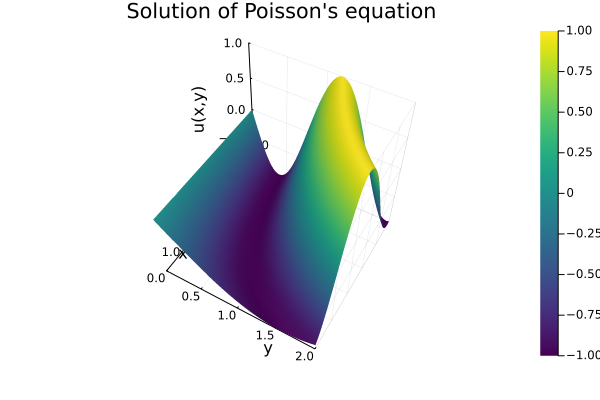

In [6]:
using Plots
surface(x,y,U',color=:viridis,
    title="Solution of Poisson's equation",      
    xaxis=("x"),yaxis=("y"),zaxis=("u(x,y)"),camera=(120,50))    

Note that there are two senses of accuracy here: solution of the discrete linear system, and discretization error. The second sense is unaffected by GMRES, of course.

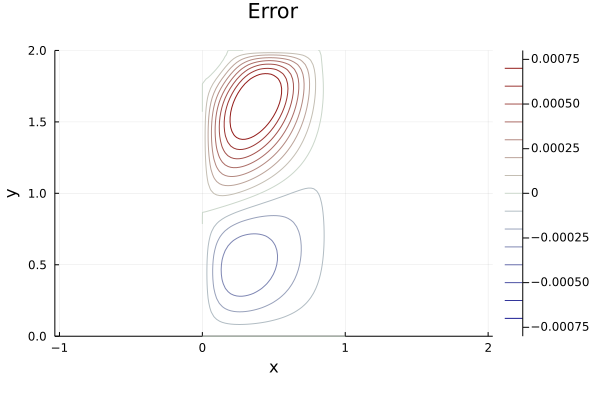

In [7]:
Û = [g([x,y]) for x in x, y in y]
contour(x,y,(U-Û)',color=:bluesreds,aspect_ratio=1,
    title="Error",clims=(-0.0008,0.0008),      
    xaxis=("x"),yaxis=("y"),zaxis=("u(x,y)"),
    right_margin=10Plots.mm)   

Note that while the Laplacian operator is nominally symmetric and negative definite, boundary conditions can wreck that structure.

## Preconditioning 

Krylov methods converge at a rate that depends strongly on the underlying linear operator. For symmetric matrices, the dependence can be characterized in terms of the spectrum of the matrix. When the ratio between the eigenvalues farthest from and closest to the origin is very large, the convergence becomes unacceptably slow. 

In the case of Poisson's equation, a second-order FD method produces a matrix with condition number $O(h^{-2})$ when using grid spacing $h$, and the number of MINRES or CG iterations grows as $O(h^{-1})$.

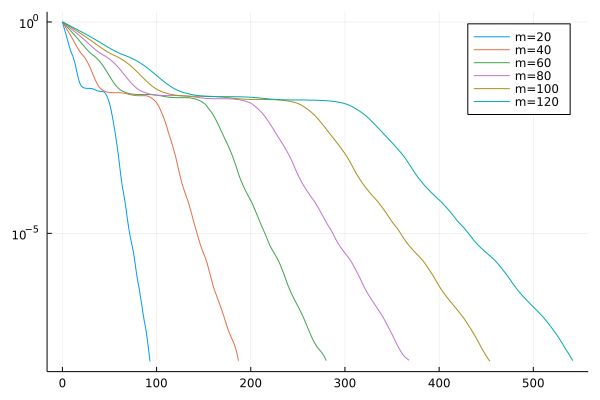

In [8]:
m = 20:20:120
plt = plot(yaxis=:log10)
for m in m
    x,y,U,stats = iterative(m,m,xspan,yspan,f,g);
    res = stats.residuals
    plot!(0:length(res)-1,res/res[1],label="m=$m")
end
plt

The above is consistent with linear growth in the number of iterations required. 

The response is to use a **preconditioner**, which is a way to apply an approximate solution process to improve the convergence rate to the actual solution. For example, if one uses a recursive coarsening procedure to approximate the original FD method, the result is a *multigrid* preconditioner that can provide convergence in $O(1)$ iterations in ideal circumstances. Another approach is to decompose the domain into pieces and simplify or ignore the interactions between them.

One strategy is known as **alternating direction implicit.** The discrete Laplace operator has the form $\bfA+\mathbf{B}$, where $\bfA$ depends only on $x$ and $\mathbf{B}$ depends only on $y$. Observe that

$$
(\bfI + s\bfA)(\bfI + s\mathbf{B}) = \bfI + s (\bfA+\mathbf{B}) + s^2 \bfA \mathbf{B},
$$

so that the matrix $\mathbf{M} = s^{-1} (\bfI + s\bfA)(\bfI + s\mathbf{B})$ contains $\bfA+\mathbf{B}$, along with extra terms. Note that 

$$
\mathbf{M}^{-1} \bfv = s (\bfI + s\mathbf{B})^{-1}(\bfI + s\bfA)^{-1} \bfv. 
$$

Each individual matrix inverse above can be calculated by operating only on one side of the rectangular reshape of $\mathbf{V}$, making them fast to perform. Since we are only looking for an approximation, we can even try ignoring the boundary conditions.

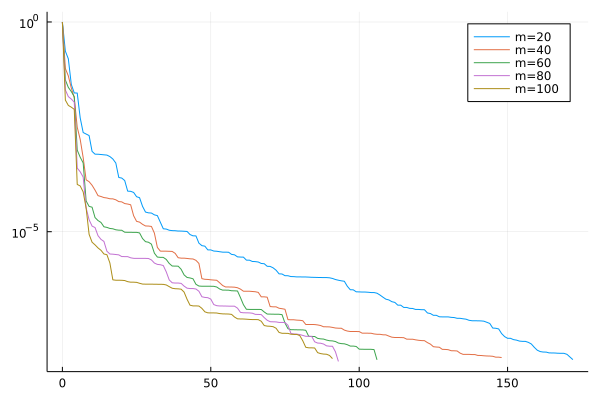

In [9]:
function iterative(m,n,xspan,yspan,f,g,prec)
    function precon(u)
        A = I + 0.1Dxx
        u = vec(A\reshape(u,m+1,n+1))      
        B = I + 0.1Dyy
        u = vec(reshape(u,m+1,n+1)/B)
        return u
    end

    x,Dx,Dxx = diffmats(m,xspan...)
    y,Dy,Dyy = diffmats(n,yspan...)
    grid = [(x,y) for x in x, y in y]

    # Identify boundary locations.
    isboundary = trues(m+1,n+1)
    isboundary[2:m,2:n] .= false
    idx = vec(isboundary);
    isinter = .!

    # forcing function / boundary values vector
    b = vec( f.(grid) )
    b[idx] = g.(grid[idx]);   # assigned values
    
    # Apply Laplacian operator with Dirichlet condition.
    function laplacian(v)
        V = reshape(v,m+1,n+1)
        AV = Dxx*V + V*Dyy'
        AV[idx] .= V[idx]   # Dirichlet condition
        return vec(AV)
    end

    A = LinearMap(laplacian,(m+1)*(n+1))
    M = LinearMap(precon,(m+1)*(n+1))
    u,stats = gmres(A,b,rtol=1e-8,history=true,M=M)
    return x,y,reshape(u,m+1,n+1),stats
end 

m = 20:20:100
plt = plot(yaxis=:log10)
for m in m
    x,y,U,stats = iterative(m,m,xspan,yspan,f,g,true);
    res = stats.residuals
    plot!(0:length(res)-1,res/res[1],label="m=$m")
end
plt

## Newton--Krylov methods

In a nonlinear problem, we have an *outer iteration* of changing linear problems for the nonlinear part, and an *inner iteration* of a Krylov method to solve the linear part. Typically one starts the inner iterations with a rather large error tolerance, since finding accurate values for a bad solution to the nonlinear problem is a waste of time. This tolerance decreases as the outer iteration homes in on the solution of the nonlinear problem. Even so, the Newton corrections need be found accurately relative to the outer solution only.